<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf


In [3]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/Git/Autoencoder_Embedding_Expert_Caracteristion_'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [4]:
#import class and methods from src
from tensorflow.keras import backend as K
from CVAE.callbacks import *
#from CVAE.cvae import compile_cvae, run_cvae
from conso.load_shape_data import *

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [6]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [7]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [8]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [9]:
calendar_info

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [10]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [11]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [13]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [14]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [15]:
meteo_records

,snow,floods,storm,hurricane,heavy_rains,cold,hot
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1825,0,0,0,0,0,0,0
1826,0,0,0,0,0,0,0
1827,0,0,0,0,0,0,0
1828,0,0,0,0,0,0,0


# Tools to evaluate the representations

In [16]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
    plt.subplot(2, 3, 5)
    plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
    plt.xlabel('latent variables')
    plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [17]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [18]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [19]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

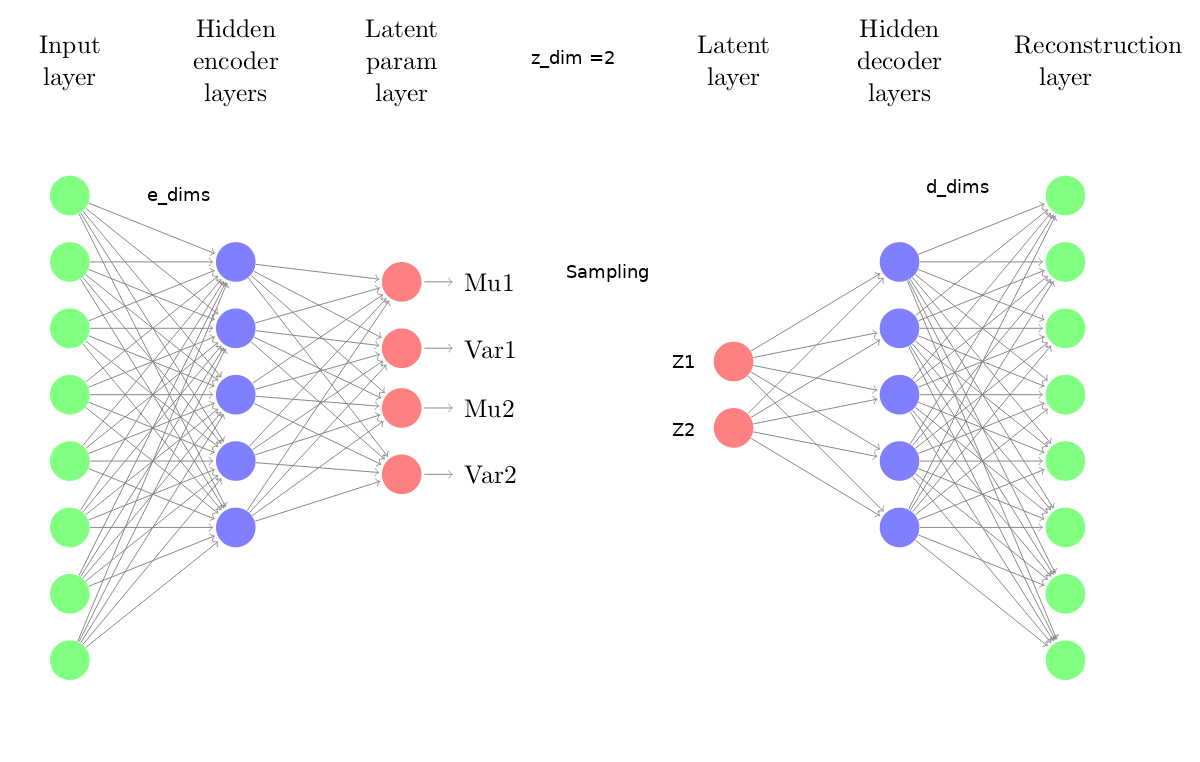

In [20]:
Image(path_main_folder+'/images/VAE.png', width=1000, height=150)

In [21]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 

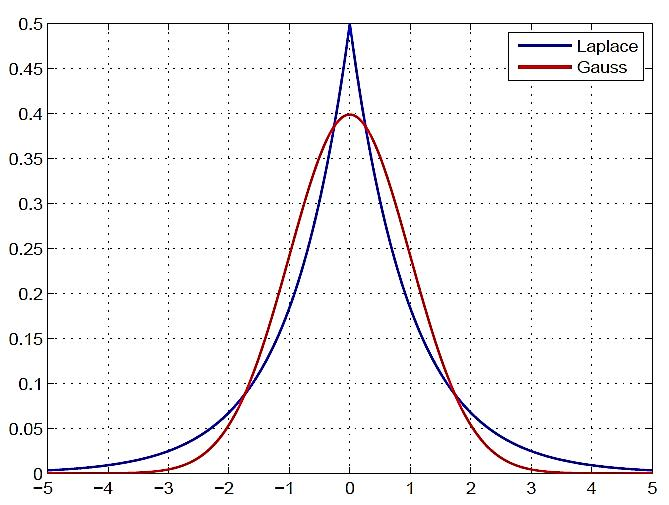

In [22]:
Image(path_main_folder+'/images/lois_laplace_normale.jpg', width=500)


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [23]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [24]:
to_cond = ["temperature", "month", "weekday"]
dataset_emb, cond_to_emb = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=to_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
weekday (1830, 1)
4


In [25]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [26]:
import importlib
import models, loss_class, params_class,AE_blocks
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)


<module 'AE_blocks' from '/home/goubetcle/Documents/Git/VAE/AE_blocks.py'>

In [1]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

NameError: name 'VAE_params' is not defined

In [ ]:
vae_params.set_model_params()
vae_params.set_training_params()

In [ ]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,24,8],[12,4],[],6]
vae_params.model_params.nb_encoder_ensemble = 1

In [ ]:

def loss_1(y_true, y_pred):
    return K.sum(y_true)

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1]

In [ ]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

In [ ]:
new_cae.build_model(vae_params)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [ ]:
new_cae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= epochs, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

In [ ]:
x_encoded = new_cae.encoder.predict(dataset_emb['train']['x'])[0]

In [ ]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [ ]:
x_hat = new_cae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

In [ ]:
prez_2D(x_encoded)

In [ ]:
#new_cae.load_model()

In [ ]:
cond_emb = new_cae.to_embedding(dataset_emb['train']['x'][1:])

In [ ]:
model_eval, importanceMatrix =evaluateLatentCode(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 7, factorDesc)

## Essai de la loss de mutual info

In [75]:
#root git folder 
name_model="cvae_mutualinfo"
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

vae_params.set_model_params()
vae_params.set_training_params()


vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[36,22,10],[12,4],[],6]
vae_params.model_params.nb_encoder_ensemble = 1


loss_weights = {"recon_loss" : 1, "kl_loss" : 0.3, "info_loss":66}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]

Default values for model architecture are:
cond_dims  :=  []
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [76]:
mi_cvae=CVAE(vae_params)
mi_cvae.VAE_params.__dict__

{'name': 'cvae_mutualinfo',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/cvae_mutualinfo',
 'model_params': <params_class.ModelParams at 0x7f1cf46000d0>,
 'training_params': <params_class.TrainingParams at 0x7f1cf406a6d0>}

In [82]:
mi_cvae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            
_______________________________________________________________________________________________

In [83]:
epochs=500

In [84]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [85]:
import callbacks
importlib.reload(callbacks)
from callbacks import *
                
histinfo = InformationHistory(h=3,alpha=1.01,dataset_train=dataset_emb['train']['x'],
                              period=np.unique(np.logspace(0,4,endpoint=True, num=500, dtype=int)),
                              infotoeval=["XZ", "X(C+Z)", "CZ", "CEmb", "XX'"], printlogger=True)

## START TRAINING ##
Mutual informations for epoch 1 are XZ :  -7.390 ; X(C+Z) :  nan ; CZ :  -5.884 ; CEmb :  -0.597 ; XX' :  -35.149
Mutual informations for epoch 2 are XZ :  -8.533 ; X(C+Z) :  nan ; CZ :  -6.578 ; CEmb :  -0.967 ; XX' :  -33.027
Mutual informations for epoch 3 are XZ :  -8.497 ; X(C+Z) :  nan ; CZ :  -7.033 ; CEmb :  -1.371 ; XX' :  -32.340
Mutual informations for epoch 4 are XZ :  -8.576 ; X(C+Z) :  nan ; CZ :  -7.429 ; CEmb :  -1.633 ; XX' :  -32.072
Mutual informations for epoch 5 are XZ :  -8.413 ; X(C+Z) :  nan ; CZ :  -7.842 ; CEmb :  -1.962 ; XX' :  -32.411
Mutual informations for epoch 6 are XZ :  -8.440 ; X(C+Z) :  nan ; CZ :  -8.197 ; CEmb :  -2.104 ; XX' :  -31.386
Mutual informations for epoch 7 are XZ :  -8.380 ; X(C+Z) :  nan ; CZ :  -8.583 ; CEmb :  -2.246 ; XX' :  -32.353
Mutual informations for epoch 8 are XZ :  -8.310 ; X(C+Z) :  nan ; CZ :  -8.979 ; CEmb :  -2.333 ; XX' :  -31.037
Mutual informations for epoch 9 are XZ :  -8.208 ; X(C+Z) :  nan ; 

Mutual informations for epoch 76 are XZ :  -2.430 ; X(C+Z) :  nan ; CZ :  -12.484 ; CEmb :  -1.450 ; XX' :  -8.127
Mutual informations for epoch 77 are XZ :  -2.404 ; X(C+Z) :  nan ; CZ :  -12.481 ; CEmb :  -1.434 ; XX' :  -7.974
Mutual informations for epoch 79 are XZ :  -2.376 ; X(C+Z) :  nan ; CZ :  -12.126 ; CEmb :  -1.372 ; XX' :  -7.755
Mutual informations for epoch 80 are XZ :  -2.362 ; X(C+Z) :  nan ; CZ :  -12.051 ; CEmb :  -1.410 ; XX' :  -7.915
Mutual informations for epoch 82 are XZ :  -2.350 ; X(C+Z) :  nan ; CZ :  -11.785 ; CEmb :  -1.442 ; XX' :  -8.130
Mutual informations for epoch 83 are XZ :  -2.339 ; X(C+Z) :  nan ; CZ :  -11.681 ; CEmb :  -1.406 ; XX' :  -7.693
Mutual informations for epoch 85 are XZ :  -2.329 ; X(C+Z) :  nan ; CZ :  -11.541 ; CEmb :  -1.383 ; XX' :  -7.735
Mutual informations for epoch 87 are XZ :  -2.310 ; X(C+Z) :  nan ; CZ :  -11.249 ; CEmb :  -1.432 ; XX' :  -7.598
Mutual informations for epoch 88 are XZ :  -2.311 ; X(C+Z) :  nan ; CZ :  -11.12

Mutual informations for epoch 289 are XZ :  -2.693 ; X(C+Z) :  nan ; CZ :  -8.198 ; CEmb :  -1.352 ; XX' :  -5.121
Mutual informations for epoch 294 are XZ :  -2.722 ; X(C+Z) :  nan ; CZ :  -8.181 ; CEmb :  -1.326 ; XX' :  -4.756
Mutual informations for epoch 299 are XZ :  -2.695 ; X(C+Z) :  nan ; CZ :  -8.088 ; CEmb :  -1.318 ; XX' :  -4.584
Mutual informations for epoch 305 are XZ :  -2.737 ; X(C+Z) :  nan ; CZ :  -8.212 ; CEmb :  -1.312 ; XX' :  -4.695
Mutual informations for epoch 311 are XZ :  -2.761 ; X(C+Z) :  nan ; CZ :  -8.112 ; CEmb :  -1.320 ; XX' :  -4.852
Mutual informations for epoch 316 are XZ :  -2.779 ; X(C+Z) :  nan ; CZ :  -8.079 ; CEmb :  -1.277 ; XX' :  -4.644
Mutual informations for epoch 322 are XZ :  -2.812 ; X(C+Z) :  nan ; CZ :  -7.989 ; CEmb :  -1.299 ; XX' :  -4.502
Mutual informations for epoch 328 are XZ :  -2.834 ; X(C+Z) :  nan ; CZ :  -8.045 ; CEmb :  -1.319 ; XX' :  -4.583
Mutual informations for epoch 335 are XZ :  -2.848 ; X(C+Z) :  nan ; CZ :  -7.91

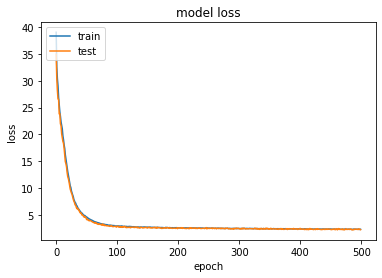

## MODEL SAVED ##


In [86]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= epochs, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

In [45]:
#mi_cvae.save()
loss_weights = {"recon_loss" : 1, "kl_loss" : 0.67, "info_loss" : 66, "mutualinfo_loss":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]


In [46]:
mi_cvae.load_model(retrieve_model_architecture=False, training_params=vae_params.training_params)

## START TRAINING ##
Mutual informations for epoch 502 are XZ :  -4.624 ; CZ :  10.606 ; CEmb :  29.695 ; ZEmb :  -23.739 ; XX' :  82.589
Mutual informations for epoch 512 are XZ :  -4.948 ; CZ :  11.346 ; CEmb :  31.295 ; ZEmb :  -24.681 ; XX' :  86.913
Mutual informations for epoch 521 are XZ :  -4.791 ; CZ :  11.709 ; CEmb :  31.394 ; ZEmb :  -25.001 ; XX' :  87.841
Mutual informations for epoch 531 are XZ :  -4.574 ; CZ :  12.148 ; CEmb :  31.237 ; ZEmb :  -25.442 ; XX' :  88.302
Mutual informations for epoch 541 are XZ :  -4.461 ; CZ :  12.475 ; CEmb :  31.375 ; ZEmb :  -25.635 ; XX' :  89.313
Mutual informations for epoch 551 are XZ :  -4.252 ; CZ :  12.828 ; CEmb :  31.222 ; ZEmb :  -25.840 ; XX' :  89.111
Mutual informations for epoch 561 are XZ :  -3.949 ; CZ :  13.207 ; CEmb :  30.869 ; ZEmb :  -26.028 ; XX' :  89.362
Mutual informations for epoch 572 are XZ :  -3.663 ; CZ :  13.606 ; CEmb :  31.040 ; ZEmb :  -26.067 ; XX' :  89.606
Mutual informations for epoch 582 are XZ : 

Mutual informations for epoch 1830 are XZ :  -2.995 ; CZ :  38.637 ; CEmb :  39.099 ; ZEmb :  -37.598 ; XX' :  101.727
Mutual informations for epoch 1864 are XZ :  -3.209 ; CZ :  39.123 ; CEmb :  39.426 ; ZEmb :  -37.839 ; XX' :  102.986
Mutual informations for epoch 1899 are XZ :  -3.220 ; CZ :  39.468 ; CEmb :  39.544 ; ZEmb :  -37.997 ; XX' :  102.844
Mutual informations for epoch 1934 are XZ :  -3.394 ; CZ :  39.666 ; CEmb :  39.616 ; ZEmb :  -38.224 ; XX' :  102.737
Mutual informations for epoch 1970 are XZ :  -3.521 ; CZ :  40.053 ; CEmb :  39.776 ; ZEmb :  -38.436 ; XX' :  102.746
Mutual informations for epoch 2007 are XZ :  -3.651 ; CZ :  40.338 ; CEmb :  39.898 ; ZEmb :  -38.729 ; XX' :  101.838
Mutual informations for epoch 2044 are XZ :  -3.843 ; CZ :  40.520 ; CEmb :  39.950 ; ZEmb :  -38.976 ; XX' :  102.731
Mutual informations for epoch 2082 are XZ :  -4.205 ; CZ :  40.736 ; CEmb :  40.130 ; ZEmb :  -39.398 ; XX' :  102.526
Mutual informations for epoch 2121 are XZ :  -4.

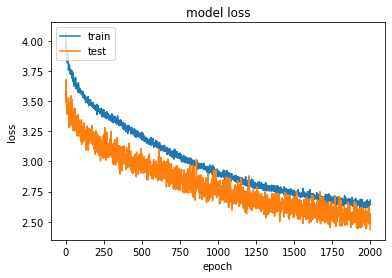

## MODEL SAVED ##


In [47]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 2000, verbose=0,
              batch_size=128, callbacks=[earl_stop, histinfo])

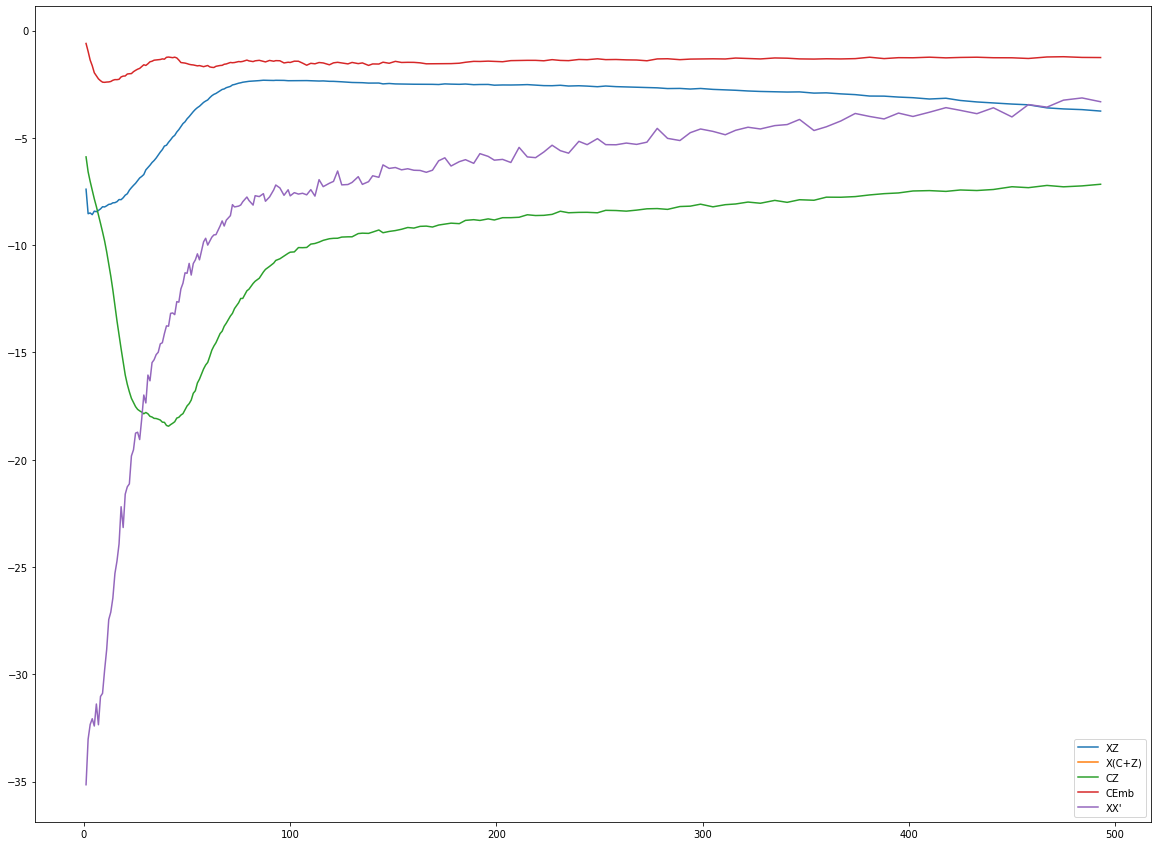

In [87]:
plt.figure(figsize=(20,15))
for key, list_val in histinfo.MI.items():
    plt.plot(histinfo.period[:len(list_val)], list_val, label=key)
#plt.yscale("log")
plt.legend()

In [141]:
histinfo.memory_epochs

1061

In [49]:
x_encoded = mi_cvae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.06


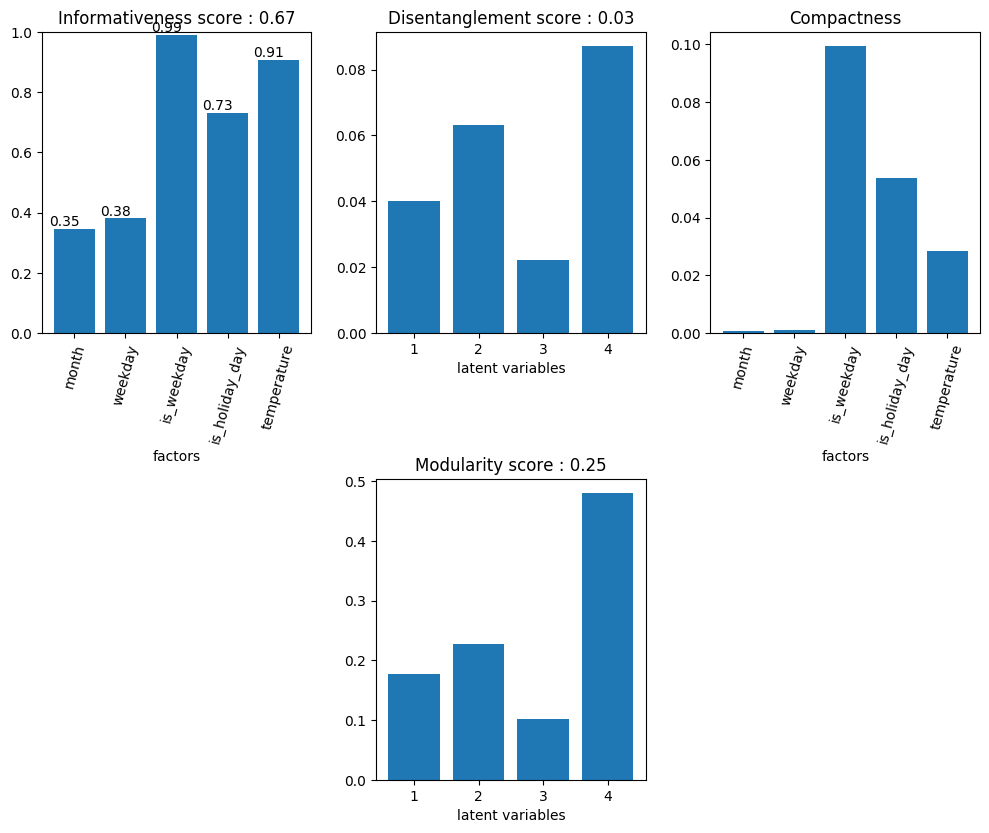

In [50]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [51]:
x_hat = mi_cvae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.9086938292644842

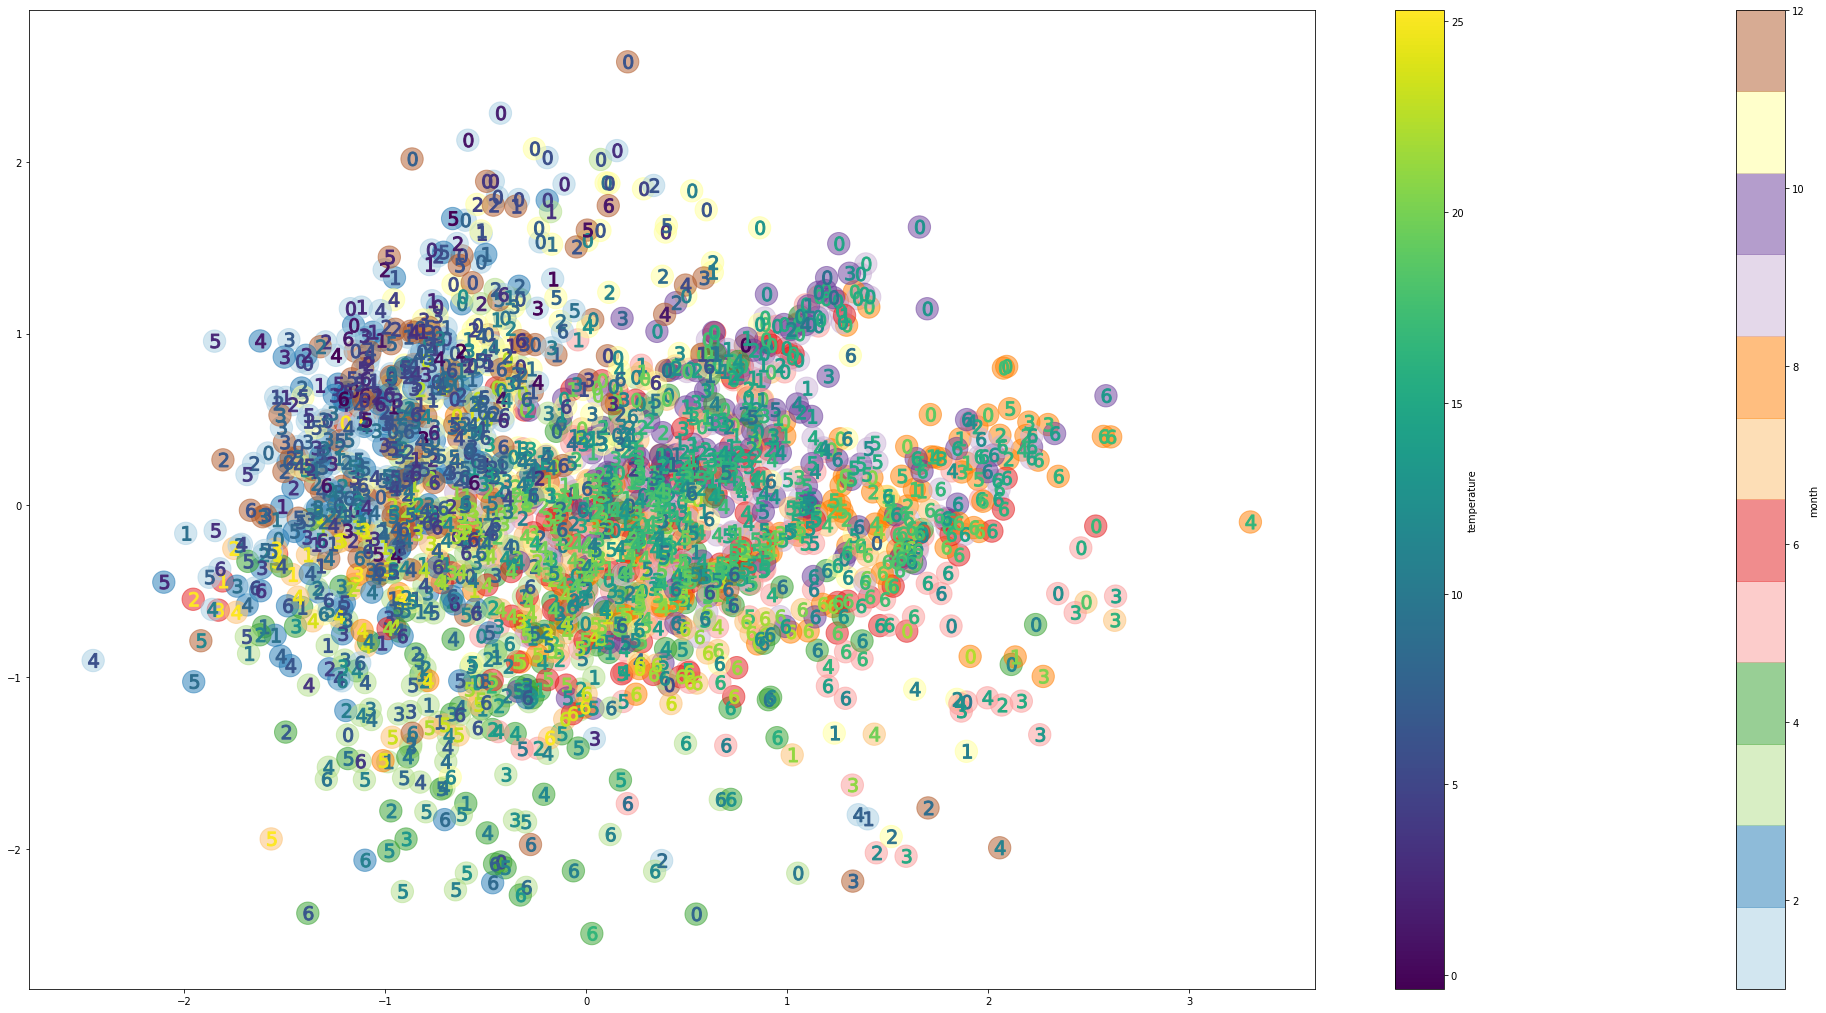

In [52]:
prez_2D(x_encoded)

In [53]:
#new_cae.load_model()

In [54]:
cond_emb = mi_cvae.to_embedding(dataset_emb['train']['x'][1:])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Mutual Information Gap : 0.32


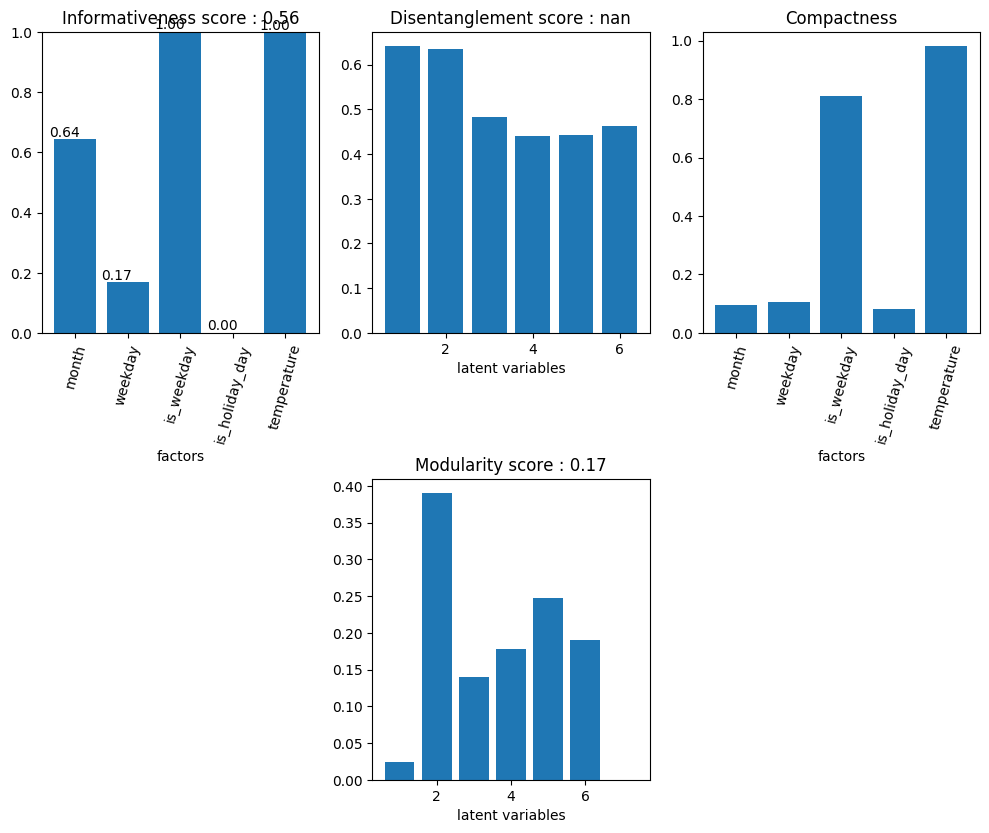

In [55]:
model_eval, importanceMatrix =evaluateLatentCode(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 7, factorDesc)

In [87]:
sigma = 4 * K.pow(K.cast(K.shape(dataset_emb['train']['x'][0])[0], dtype='float64'), -1. / (4. + 1.))

gram_x = build_gram_matrix(dataset_emb['train']['x'][0], sigma)

In [47]:
infotoeval=["XZ", "ZC"]
"C"in "".join(infotoeval)

True

In [114]:
build_mutualinfo_loss(y_true=dataset_emb['train']['y'], y_pred=dataset_emb['train']['y'], gram_x=gram_x,
                      gram_c=gram_c, latent_mu=x_encoded, h=1, alpha=1.01, kappa=1.)

<tf.Tensor: shape=(), dtype=float32, numpy=5.044131>

In [75]:
e,v = tf.linalg.eigh(trace_normalize(gram_x))

In [76]:
alpha=1.01
K.log(K.sum(K.pow(e, alpha))) / K.cast((1. - alpha) * K.log(2.), dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=6.8545572441325255>

In [77]:
K.pow(e, alpha)

<tf.Tensor: shape=(1830,), dtype=float64, numpy=
array([4.18406683e-08, 4.63912583e-08, 4.70713456e-08, ...,
       4.27793103e-02, 5.14365250e-02, 1.14571219e-01])>

In [113]:
if True:
        
    gram_z = build_gram_matrix(x_encoded, sigma)

    cond_MI = Renyi_entropy(trace_normalize(gram_z), alpha) + \
              Renyi_entropy(trace_normalize(gram_c), alpha) -\
              Renyi_entropy(trace_normalize(gram_c * gram_z), alpha)

    input_MI = Renyi_entropy(trace_normalize(gram_z), alpha) + \
               Renyi_entropy(trace_normalize(gram_x), alpha) -\
               Renyi_entropy(trace_normalize(gram_x * gram_z), alpha)
    
    K.cast(1. / input_MI + cond_MI, dtype='float32')

In [150]:
gram_z = build_gram_matrix(x_encoded[:2,:], sigma)
gram_z

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[1.        , 0.61356286],
       [0.61356286, 1.        ]])>

In [125]:
histinfo.MI

{'XZ': [-15.496503343877535], 'CZ': [0.18380007646106833], 'Cemb': []}

In [123]:
emb = mi_cvae.model.get_layer("encoder").get_layer('emb')
emb.predict(dataset_emb["train"]["x"][1:])

array([[0.       , 0.       , 0.       , ..., 0.       , 3.1454184,
        1.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.7158184,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.5873153,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.9883095,
        1.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 3.7429252,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 4.0853496,
        0.       ]], dtype=float32)

{'recon_loss': 1, 'mutualinfo_loss': 1}